# Fine-tune R-CNN model for Cereal Killer
Based on: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Notes: 
- Had to downgrade numpy from 1.18.1 to 1.17.4
- Commented out line 88 (torch.cuda.synchronize()) in engine.py. 

In [24]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import time
import copy

import sys
sys.path.insert(0, os.path.join('..', 'scripts'))
from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Create train, validation, and test sets
---

In [2]:
class CerealKillerDataset(object):
    def __init__(self, root, all_targets, transforms=None):
        self.root = root
        self.transforms = transforms
        #load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNG"))))
        
        self.all_targets = all_targets
        
    def __getitem__(self, idx):
        # img filename
        img_file = self.imgs[idx]
        # load images and labels
        img_path = os.path.join(self.root, "PNG", img_file)
        # open image
        img = Image.open(img_path).convert("RGB")
        # get target info for this image
        targets = self.all_targets[img_file]
        
        # get class and bounding box coordinates
        label_names = []
        label_ids = []
        boxes = []
        for target in targets:
            label_names.append(target['class_name'])
            label_ids.append(target['class_id'])
            boxes.append(target['bbox'])

        # convert target into to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id = torch.tensor([idx])
        label_ids = torch.as_tensor(label_ids, dtype=torch.int64)
        
        # add area and incrowd to target 
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(targets),), dtype=torch.int64)

        # create dictionary of target info
        target = {}
        target["boxes"] = boxes
        target["image_id"] = image_id
        target["labels"] = label_ids
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:                                     # If a transformation function was provided,
            #img = self.transform(img)                          #   Apply a transformation to the image
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Load target info (bounding boxes and classes for all images)

In [3]:
target_path = os.path.join('..', 'data', 'synthesized', 'targets.npy')
all_targets = np.load(target_path, allow_pickle=True)[()]

# look at target infor for first image
all_targets['00000.png']

[{'class_name': 'FFS', 'class_id': 2, 'bbox': [135, 35, 222, 155]},
 {'class_name': 'LCH', 'class_id': 0, 'bbox': [58, 76, 108, 154]},
 {'class_name': 'GNS', 'class_id': 17, 'bbox': [36, 169, 63, 217]},
 {'class_name': 'RPS', 'class_id': 21, 'bbox': [0, 84, 44, 157]},
 {'class_name': 'CTC', 'class_id': 1, 'bbox': [140, 155, 176, 208]},
 {'class_name': 'COF', 'class_id': 15, 'bbox': [42, 15, 70, 64]}]

### Plot image from CerealKillerDataset to ensure it's working properly

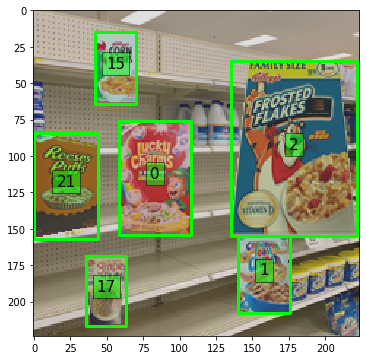

In [4]:
train_dataset = CerealKillerDataset('../Data/synthesized', all_targets)

# get random image
img, target = train_dataset[0]

# plot
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(np.array(img));

for box, label in zip(target['boxes'], target['labels']):
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=3, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), str(label.item()), fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')

In [5]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# code for debugging
#train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))

#print(train_dataset)
#d1 = train_dataset[0]
#d2 = train_dataset[1]

#print(d1[0].shape)
#print(d2[0].shape)

#print(train_dataset[0][1]['boxes'].shape)
#print(train_dataset[1][1]['boxes'].shape)

#print(d2)

### Calculate mean and std. dev. of pixel values across dataset

In [ ]:
# simple_transform = T.Compose([
#     T.ToTensor()
# ])

# #train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=simple_transform)
# train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))
# mean = 0.
# std = 0.
# for img, _ in train_dataset:
#     mean += img.mean([1,2])
#     std += img.std([1,2])
# mean /= len(train_dataset)
# std /= len(train_dataset)

# print(f'Mean: {mean}')
# print(f'Std: {std}')

### Add normalization transorm to `simple_transform` function

In [ ]:
#simple_transform = T.Compose([
#    T.ToTensor(),
#    T.Normalize(mean=[0.5189, 0.4546, 0.3909],   # Normalize an image with channel-wise means
#                std=[0.2370, 0.2326, 0.2393])    #   and standard deviations
#])

In [ ]:
# #train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, transform=simple_transform)
# train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))

# img, target = train_dataset[10]
# plt.imshow(img.permute(1, 2, 0));

# print(f'Img Mean: {img.mean():.2f}')    # Calculate the mean of the pixel values in the image
# print(f'Img Std: {img.std():.2f}')      # Calculate the standard deviation of the pixel values in the image

### Define transforms for training and testing

In [ ]:
#train_transform = T.Compose([
#    T.RandomVerticalFlip(),                      # Flip the image vertically
#    T.RandomHorizontalFlip(),                    # Flip the image horizontally
#    T.ToTensor(),
#    T.Normalize(mean=[0.5189, 0.4546, 0.3909],   # Normalize an image with channel-wise means
#                std=[0.2370, 0.2326, 0.2393])    #   and standard deviations
#])

#test_transform = simple_transform

### Make train, validate, test sets
Allocations: Train = 68%; Validation = 12%; Test = 20%

In [6]:
# First, load all data in each
train_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))
val_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))
test_dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=False))

# Now split
num_data = len(train_dataset)
indices = torch.randperm(num_data).tolist()

train_dataset = torch.utils.data.Subset(train_dataset, indices[:np.int(np.floor(num_data * 0.68))])
val_dataset = torch.utils.data.Subset(val_dataset, indices[np.int(np.floor(num_data * 0.68)):np.int(np.floor(num_data * 0.8))])
test_dataset = torch.utils.data.Subset(test_dataset, indices[np.int(np.floor(num_data * 0.8)):])

## Training new detector and classifier using pre-trained Fast R-CNN
---

### Test the `forward()` method

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = CerealKillerDataset('../Data/synthesized', all_targets, get_transform(train=True))

# def collate_fn(batch):
#     return tuple(zip(*batch))

# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

# # For Training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions
# predictions

## Set model and training parameters

In [7]:
num_epochs = 1
learning_rate = 0.005
momentum = 0.9
weight_decay=0.0005
batchsize = 10
num_workers = 4

# Load Faster R-CNN model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# number of classes
classes = []
for key in all_targets.keys():
    for subdict in all_targets[key]:
        classes.append(subdict['class_id'])
classes = np.unique(classes)    
num_classes = len(classes)
print(num_classes)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Send the model to the computing device (train on CPU if GPU not available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
# Create train and val dataloaders that handle batchsize, shuffling the dataset each epoch, and multicore processing.
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers, collate_fn=utils.collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=True, num_workers=num_workers, collate_fn=utils.collate_fn)       

22


In [8]:
since = time.time()
best_model_name = ''

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_evaluator = evaluate(model, val_dataloader, device=device)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
# Save model weights
best_model_wts = copy.deepcopy(model.state_dict())
if os.path.exists(best_model_name): os.remove(best_model_name)
best_model_name = f'./best_model_weights_epoch_{epoch+1}.pt'
torch.save(model.state_dict(), best_model_name)

/home/perry/anaconda3/envs/cerealkiller_py37/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/perry/anaconda3/envs/cerealkiller_py37/lib/python3.7/site-packages/torchvision/models/detection/_utils.py:321: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1591081608968/work/torch/csrc/utils/python_arg_parser.cpp:760.)
  match_quality_mat

Epoch: [0]  [0/2]  eta: 0:03:42  lr: 0.005000  loss: 3.9977 (3.9977)  loss_classifier: 3.2853 (3.2853)  loss_box_reg: 0.6608 (0.6608)  loss_objectness: 0.0391 (0.0391)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 111.1163  data: 0.4896
Epoch: [0]  [1/2]  eta: 0:01:10  lr: 0.005000  loss: 3.8143 (3.9060)  loss_classifier: 3.2853 (3.2917)  loss_box_reg: 0.4712 (0.5660)  loss_objectness: 0.0347 (0.0369)  loss_rpn_box_reg: 0.0101 (0.0113)  time: 70.0013  data: 0.2448
Epoch: [0] Total time: 0:02:20 (70.0137 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:20  model_time: 19.8281 (19.8281)  evaluator_time: 0.0196 (0.0196)  time: 20.5290  data: 0.6811
Test: Total time: 0:00:20 (20.5466 s / it)
Averaged stats: model_time: 19.8281 (19.8281)  evaluator_time: 0.0196 (0.0196)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDet

## Model inference

In [29]:
# Load Faster R-CNN model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# number of classes
classes = []
for key in all_targets.keys():
    for subdict in all_targets[key]:
        classes.append(subdict['class_id'])
classes = np.unique(classes)    
num_classes = len(classes)
print(num_classes)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

weights_file = 'best_model_weights_epoch_1.pt'

weights = torch.load(weights_file, map_location=lambda storage, loc:storage)
model.load_state_dict(weights)
model.eval()
print('Model ready.')


22
Model ready.


/home/perry/anaconda3/envs/cerealkiller_py37/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


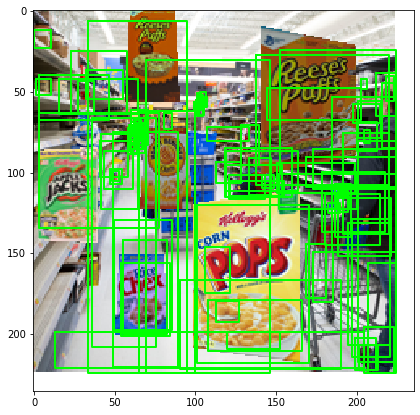

In [65]:
index = np.random.randint(0, len(test_dataset))
img, target = test_dataset[index]

preprocessed_img = img.unsqueeze(0)

with torch.no_grad():                                     # Without tracking gradients,
    pred = model(preprocessed_img)
   
bboxes = np.asarray(pred[0]['boxes'])

# plot
fig, ax = plt.subplots(1, figsize=(7,7))
ax.imshow(img.permute(1, 2, 0));

for box in bboxes:
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=2, color='lime')
